## 1. Introduction

In [1]:
# import essential libraries
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
from sklearn.model_selection import train_test_split
import tempfile
import matplotlib.pyplot as plt
import random

## 2. Load The Data

In [2]:
# count of TFRecords
tfr_list = os.listdir('data/')
print('TFRecord file count: {}'.format(len(tfr_list)))

TFRecord file count: 256


In [3]:
# read in csv
df = pd.read_csv('preprocessed_data.csv').drop(columns='Unnamed: 0')
print(df.shape)
df.head()

(112120, 15)


No Finding  Atelectasis  Consolidation  Infiltration  Pneumothorax  Edema  \
0       False        False          False         False         False  False   
1       False        False          False         False         False  False   
2       False        False          False         False         False  False   
3        True        False          False         False         False  False   
4       False        False          False         False         False  False   

   Emphysema  Fibrosis  Effusion  Pneumonia  Pleural_Thickening  Cardiomegaly  \
0      False     False     False      False               False          True   
1       True     False     False      False               False          True   
2      False     False      True      False               False          True   
3      False     False     False      False               False         False   
4      False     False     False      False               False         False   

   Nodule   Mass  Hernia  
0   False  False   False  
1   False  False   False  
2   False  False   False  
3   False  False   False  
4   False  False    True

Now we will load in our data. For this notebook, we will be importing the TFRecord Files. It is good practice to divide the training set data into two. The smaller dataset will be the validation set. Having a validation set is useful to prevent overfitting as the finetuning of the model will be done by calculating metrics on the validation set and not the training set.

In [4]:
# grabbing TFRecords
tfr_list = os.listdir('data/')
tfrlist = ['data/' + x for x in tfr_list]
FILENAMES = tf.io.gfile.glob(tfrlist)

# train_test_split
ALL_INDEX = list(range(len(FILENAMES)))
TRAIN_VALID_INDEX = random.sample(ALL_INDEX, int(len(ALL_INDEX) * 0.8)) 
'''
random.sample's params:
    sequence: can be a list, tuple, string, or set
    k: an integer value, it specify the length of a sample
'''

TRAIN_INDEX = random.sample(TRAIN_VALID_INDEX, int(len(TRAIN_VALID_INDEX) * 0.9))
VALID_INDEX = list(set(TRAIN_VALID_INDEX) - set(TRAIN_INDEX))
TEST_INDEX = list(set(ALL_INDEX) - set(TRAIN_VALID_INDEX))

# Getting lists for Train, Validation and Test
TRAINING_FILENAMES, VALID_FILENAMES, TEST_FILENAMES = [FILENAMES[index] for index in TRAIN_INDEX], \
                                                      [FILENAMES[index] for index in VALID_INDEX], \
                                                      [FILENAMES[index] for index in TEST_INDEX]

# Check
print('Train TFRecord Files: {}'.format(len(TRAINING_FILENAMES)))
print('Validation TFRecord Files: {}'.format(len(VALID_FILENAMES)))
print('Test TFRecord Files: {}'.format(len(TEST_FILENAMES)))

Train TFRecord Files: 183
Validation TFRecord Files: 21
Test TFRecord Files: 52


We set up the parameters to pass them in some of the functions below.

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 70
IMAGE_SIZE = [1024, 1024]
IMAGE_RESIZE = [256, 256]

# feature space for parsing
feature_description = {}
features=list(df.columns)[1:]
for elem in features:
    feature_description[elem] = tf.io.FixedLenFeature([], tf.int64)
    
feature_description['image'] = tf.io.FixedLenFeature([], tf.string)
feature_description

{'Atelectasis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Consolidation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Infiltration': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumothorax': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Edema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Emphysema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Fibrosis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Effusion': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumonia': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pleural_Thickening': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Cardiomegaly': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Nodule': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Mass': FixedLenFeature(shape=[], dtype=tf.int64, default_va

### 2.1 Define Functions

In [6]:
def decode_image(image):
    '''
    The images have to be converted to tensors so that it will be a valid input in our model. 
    As images utilize an RBG scale, we specify 3 channels.
    It is also best practice to normalize data before it is is fed into the model. 
    For our image data, we will scale it down so that the value of each pixel will range 
    from [0, 1] instead of [0. 255].
    We also reshape our data so that all of the images will be the same shape. 
    Although the TFRecord files have already been reshaped for us, it is best practice 
    to reshape the input so that we know exactly what's going in to our model.
    '''
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):   # Reading the file
    '''
    This function uses the above defined feature description to decode the image and its label. 
    With the loop, it extracts the feature's labels as a one-hot encoded list.
    No Findings would be a zero vector.
    '''
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_RESIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = []
    for val in features: label.append(example[val])
    return image, label

def load_dataset(filenames, labeled=True, ordered=False):
    '''
    The TFRecordDataset weaves together the individiual TFRecords, essentially treating them as one dataset. 
    Our dataset is not ordered in any meaningful way, so the order can be ignored when loading our dataset. 
    By ignoring the order and reading files as soon as they come in, it will take a shorter time to load the data.
    '''
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

We define the following three functions to get our three different datasets.

In [7]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
#     dataset = dataset.map(num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

The following cell returns the number of images we have in each dataset. Notice that the training dataset has the most images. This is normal, as having more training points will allow the model to learn more.

In [8]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 80150 training images, 9198 validation images, 22772 unlabeled test images


## 3. Explore our Data

Define two objects, one is a training dataset and the other is a valid dataset.

In [9]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

Now, let's visualize 30 random samples in the training dataset.

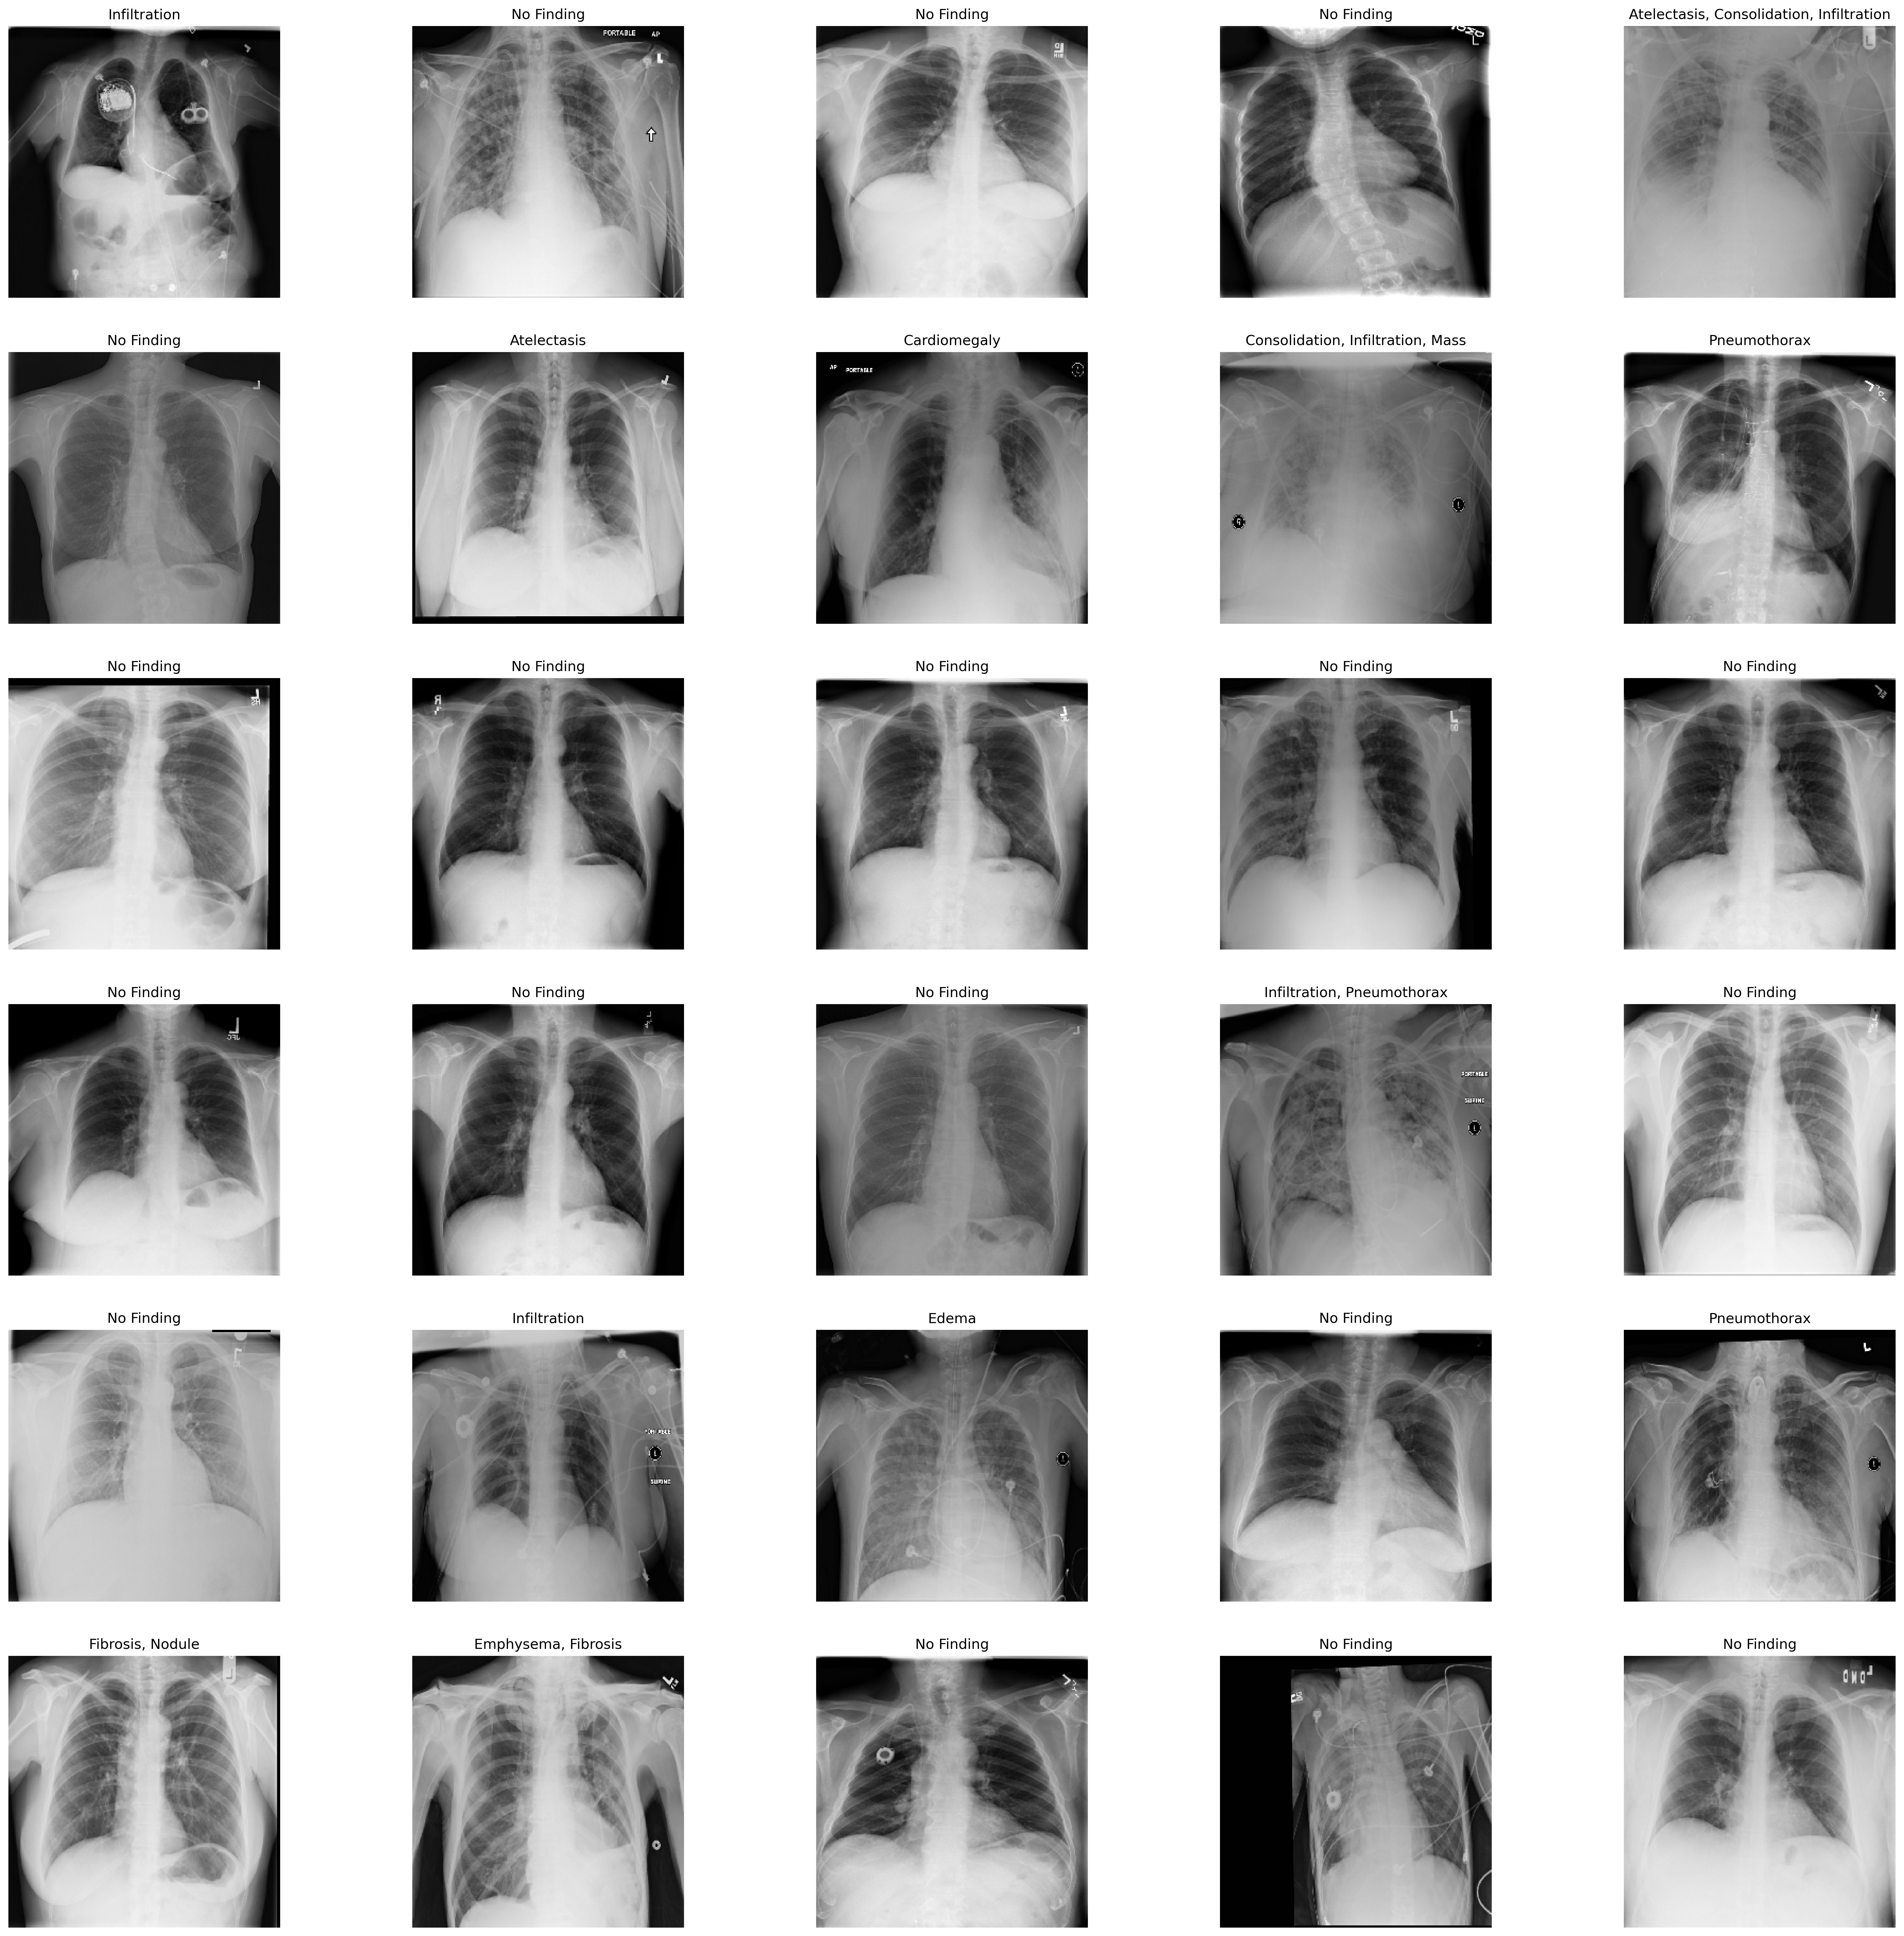

In [10]:
# Visualising some examples
plt.rcParams['figure.dpi']=300
image_viz, label_viz = next(iter(train_dataset))

def show_batch(X, Y):
    plt.figure(figsize=(30, 30))
    for n in range(30):
        ax = plt.subplot(6, 5, n + 1)
        plt.imshow(X[n])
        result = [x for i, x in enumerate(features) if Y[n][i]]
        title = ', '.join(result)
        if result == []: title = 'No Finding'
        plt.title(title)
        plt.axis('off')

show_batch(image_viz.numpy(), label_viz.numpy())

## 4. Modeling (Transfer Learning)

Now that our data has been loaded, we will now start building our model.

### 4.1 Define The Learning Rate

In [11]:
def exponential_decay(lr0, s):
    '''
    This function allows for the model to change the learning rate as it runs each epoch. 
    Having a learning rate that is too high will prevent our model from converging. 
    However, having a learning rate that is too small will cause our model to run for far too long. 
    With this function, the model will know how to change its learning rate after each epoch and 
    update the learning rate itself to allow for increased efficiency while still allowing the model to converge.
    '''
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

### 4.2 Build our Base Model (Transfer Learning)

Transfer learning is a great way to reap the benefits of a well-trained model without having the train the model ourselves. For this notebook, we want to import the VGG16 model. As this model has already been trained, we do not want to change the weights in this model and must set its trainable attribute to False. We also don't want to include the top layers because the classification that we want to accomplish in this model is not the same as the classification that the model was originally trained on. .

In [ ]:
# modeling
def make_model(output_bias = None, metrics = None):    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = tf.keras.applications.Xception(input_shape=(IMAGE_RESIZE[0], IMAGE_RESIZE[1], 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(14, activation='sigmoid',
                              bias_initializer=output_bias)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

In [12]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

### 4.3 Deciding Our Evaluation Metrics

When we compile our model, we do not want our metric to be `accuracy`. If we run the model, with an accuracy metric, it will give us false confidence in our model. If we look at the dataset, we see that 98% of the images are classifed as benign, `0`. Now, if accuracy was the sole determinant of our model, a model that always outputs 0 will achieve a high accuracy although the model is not good. Additionally, for the type of prediction we are making, it is riskier to predict a malignant tumor as benign than it is to predict a benign tumor as malignant. Thus, our metric should not be just accuracy. The competition scores the model by finding the area under the ROC curve, which is why our metric will be set to `keras.metrics.AUC`.

In [ ]:
model = make_model(metrics=tf.keras.metrics.AUC(name='auc'))

We can use callbacks to stop training when there are no improvements in our validation set predictions, and this stops overfitting. Additionally, we can save the best weights for our model so that it doesn't have to be retrained. At the end of the training process, the model will restore the weights of its best iteration.

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
history = model.fit(
    train_dataset, epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    class_weight=class_weight
)

## 5. Model Evaluation and Predicting results

In [ ]:
test_dataset = get_test_dataset()

_, test_auc = model.evaluate(test_dataset, verbose=0)

print('Test auc:', test_auc)

In [ ]:
# plot loss
ax = plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
ax.axes.xaxis.set_visible(False)

# plot accuracy
plt.subplot(212)
plt.title('AUC')
plt.plot(history.history['auc'], color='blue', label='train')
plt.plot(history.history['val_auc'], color='orange', label='validation')

In [ ]:
fitted_model = model.predict(test_dataset)

In [ ]:
image_viz, label_viz = next(iter(test_dataset))

def show_batch(X, Y_act):
    plt.figure(figsize=(25, 30))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        ax = plt.imshow(X[n])
        result = [x for i, x in enumerate(features) if Y_act[n][i]]
        title = "+".join(result)
        if result == []: title = "No Finding"
        title = "Actual:\n" + title
        title += "\n\n Prediction:\n" + str(fitted_model[n]) + "\n\n My interpretation:\n"
        threshold = 0.5
        result = []
        for i, _ in enumerate(features):
            if fitted_model[n][i] > threshold:
                result.append(1)
            else:
                result.append(0)
        result = np.asarray(result)
        if np.linalg.norm(result) == 0:
            title += "No Finding"
        else:
            result = [x for i, x in enumerate(features) if result[i]]
            additional_title = "+".join(result)
            title += additional_title
            
        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

In [ ]:
def show_batch_predictions(image_batch):
    plt.figure(figsize=(25, 30))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        ax = plt.imshow(image_batch[n])
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(model.predict(img_array)[0])
        plt.axis("off")


image_batch = next(iter(test_dataset))

show_batch_predictions(image_batch)

## 6.

In [13]:
# modeling
def make_model(output_bias = None, metrics = None):    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = tf.keras.applications.Xception(input_shape=(IMAGE_RESIZE[0], IMAGE_RESIZE[1], 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    # define a for loop for layers
    for layer in base_model.layers[-5:]:
        layer.trainable=True
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(14, activation='sigmoid',
                              bias_initializer=output_bias)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

In [14]:
model2 = make_model(metrics=tf.keras.metrics.AUC(name='auc'))

In [15]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
history = model2.fit(
    train_dataset, epochs=100,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
#     class_weight=class_weight
)

Epoch 1/100
1145/1145 [==============================] - 8194s 7s/step - loss: 0.1789 - auc: 0.7783 - val_loss: 0.1704 - val_auc: 0.8102


D:\Users\tvo10\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
1145/1145 [==============================] - 7941s 7s/step - loss: 0.1708 - auc: 0.8049 - val_loss: 0.1692 - val_auc: 0.8145
Epoch 3/100
1145/1145 [==============================] - 7930s 7s/step - loss: 0.1689 - auc: 0.8126 - val_loss: 0.1684 - val_auc: 0.8169
Epoch 4/100
1145/1145 [==============================] - 7920s 7s/step - loss: 0.1675 - auc: 0.8173 - val_loss: 0.1693 - val_auc: 0.8136
Epoch 5/100
1145/1145 [==============================] - 7936s 7s/step - loss: 0.1665 - auc: 0.8211 - val_loss: 0.1684 - val_auc: 0.8183
Epoch 6/100
1145/1145 [==============================] - 7951s 7s/step - loss: 0.1657 - auc: 0.8236 - val_loss: 0.1694 - val_auc: 0.8136
Epoch 7/100
1145/1145 [==============================] - 7932s 7s/step - loss: 0.1655 - auc: 0.8250 - val_loss: 0.1676 - val_auc: 0.8209
Epoch 8/100
1145/1145 [==============================] - 7912s 7s/step - loss: 0.1647 - auc: 0.8276 - val_loss: 0.1688 - val_auc: 0.8163
Epoch 9/100
1145/1145 [==================

In [17]:
test_dataset = get_test_dataset()

_, test_auc = model2.evaluate(test_dataset, verbose=0)

print('Test auc:', test_auc)

Test auc: 0.8237475752830505


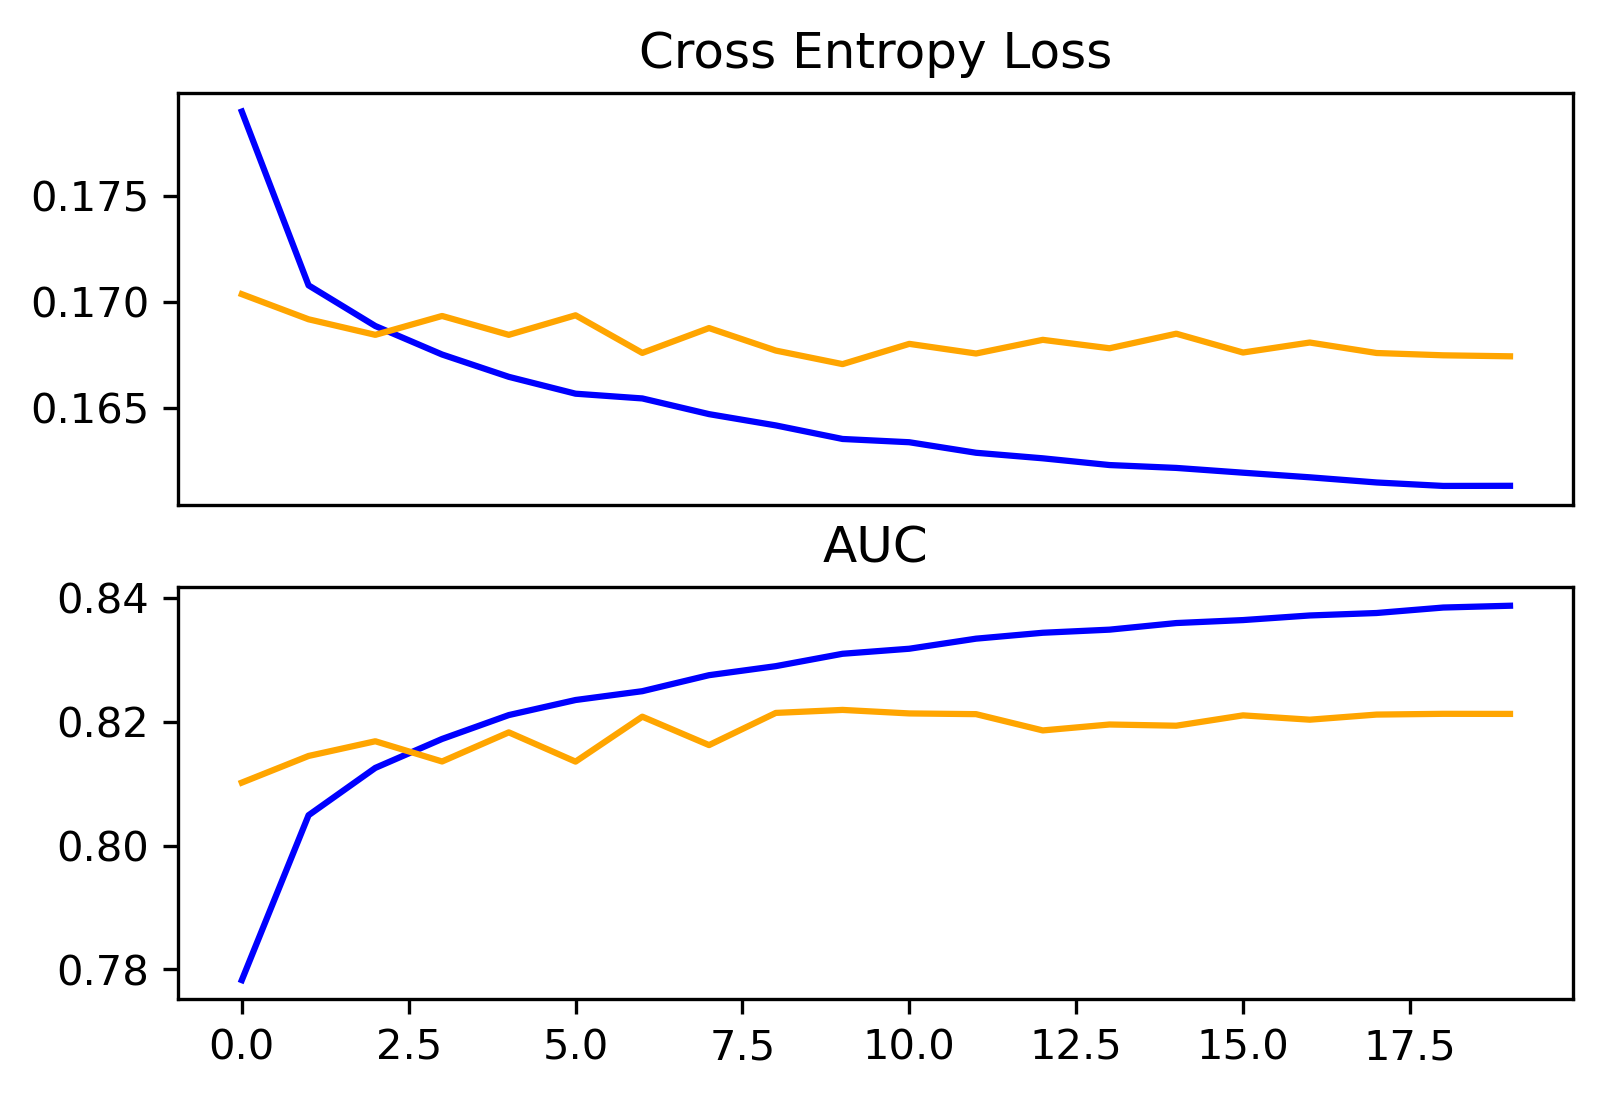

In [18]:
# plot loss
ax = plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
ax.axes.xaxis.set_visible(False)

# plot accuracy
plt.subplot(212)
plt.title('AUC')
plt.plot(history.history['auc'], color='blue', label='train')
plt.plot(history.history['val_auc'], color='orange', label='validation')

In [20]:
fitted_model = model2.predict(test_dataset)

In [25]:
image_viz, label_viz = next(iter(test_dataset))

def show_batch(X, Y_act):
    plt.figure(figsize=(25, 40))
    for n in range(12):
        ax = plt.subplot(4, 3, n + 1)
        ax = plt.imshow(X[n])
        result = [x for i, x in enumerate(features) if Y_act[n][i]]
        title = "+".join(result)
        if result == []: title = "No Finding"
        title = "Actual:\n" + title
        title += "\n\n Prediction:\n" + str(fitted_model[n]) + "\n\n My interpretation:\n"
        threshold = 0.5
        result = []
        for i, _ in enumerate(features):
            if fitted_model[n][i] > threshold:
                result.append(1)
            else:
                result.append(0)
        result = np.asarray(result)
        if np.linalg.norm(result) == 0:
            title += "No Finding"
        else:
            result = [x for i, x in enumerate(features) if result[i]]
            additional_title = "+".join(result)
            title += additional_title
            
        plt.title(title)
        plt.axis("off")

show_batch(image_viz.numpy(), label_viz.numpy())

### 6. Modeling (CNN)

In [ ]:
# Define CNN model
# The CNN is defined similar to an ImageNet model
def define_model(in_shape=(image_size[0], image_size[1], 3), out_shape=len(heads)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(out_shape, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=lr_scheduler),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC(name="auc")])
    return model

In [ ]:
# Running the model
# Due to a glitch, I could only set validation_steps and not steps_per_epoch (it kept stopping at epoch 2!).
# It just means in epoch 1, it shows /Unknown. However it is known from the frame above how many steps 
# are to be taken.

model = define_model() 

history = model.fit(
    train_dataset, epochs=10,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps = VALID_STEPS,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)